In [1]:
import ee
import sys
import matplotlib.pyplot as plt
from IPython.display import Image, display
import folium
import os
import rasterio

In [2]:
# local imports from Next Day Wildfire Spread repository
sys.path.append("/home/leo-schmidt/code/constantbourdrez/Wildfaire/wildfaire/earthengine")
from export_ee_data import _get_time_slices, _get_all_image_collections, _get_all_feature_bands, _get_all_response_bands
import ee_utils

# Initialization

In [4]:
# authenticate
# needs to be done every couple of days
# need to figure out how to do this in a .py file because it opens up a browser window for authentication
# ee.Authenticate()

# initialize engine
ee.Initialize()

# test if it worked
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


# Usage examples from Google Earth Engine documentation

## Extract info

In [4]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


## Display as image

In [5]:
# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbURL({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

## Show as Folium map

In [6]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

# Testing out the Google Research repo

## Images / Image collections

In [7]:
image_collections, time_sampling = _get_all_image_collections()
image_collections

{'drought': <ee.imagecollection.ImageCollection at 0x7f54faafb370>,
 'vegetation': <ee.imagecollection.ImageCollection at 0x7f54faaf8c40>,
 'weather': <ee.imagecollection.ImageCollection at 0x7f54faafabc0>,
 'fire': <ee.imagecollection.ImageCollection at 0x7f54faaf9780>}

In [5]:
features = _get_all_feature_bands() + _get_all_response_bands()
features

['elevation',
 'population',
 'pdsi',
 'NDVI',
 'pr',
 'sph',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc',
 'PrevFireMask',
 'FireMask']

# Export EE data based on export_ee_data.py

## Getting coordinates from .tif files

In [11]:
coordinates = []

raster_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'wildfaire_website', 'rasters'))

for file in os.listdir(raster_folder):
    if file.endswith('.tif'):
        with rasterio.open(os.path.join(raster_folder,file)) as raster_img:
            fire_array = raster_img.read()
            bounds = raster_img.bounds
            coordinates.append(ee.Geometry.Rectangle(bounds))
            
coordinates[0].getInfo()

{'type': 'Polygon',
 'coordinates': [[[-119.28815532699998, 45.750833369],
   [-118.64815532699998, 45.750833369],
   [-118.64815532699998, 46.390833369],
   [-119.28815532699998, 46.390833369],
   [-119.28815532699998, 45.750833369]]]}

In [14]:
#test_coord = ee.Geometry.Rectangle([-105.26363784169818, 35.598637841698185, -105.83856215830183, 36.17356215830181])

test_coord = coordinates[0]

## Get data from EE

In [16]:
### DEFINE CONSTANTS ###

start_date = ee.Date('2022-06-15')
start_days = [0] # start at start_date (day 0)
end_date = ee.Date('2023-07-16')
kernel_size = 64 # km

sampling_scale = 1000 # meters

geometry = test_coord
# geometry = ee.Geometry.Rectangle(ee_utils.COORDINATES['US'])

### STATIC DATA ###

# Get elevation data
elevation = ee_utils.get_image(ee_utils.DataType.ELEVATION_SRTM)

# Get population data
# and select the most recent
population = ee_utils.get_image_collection(ee_utils.DataType.POPULATION)
population = population.sort('system:time_start', False).first().rename('population')

### DYNAMIC DATA ###

# (Drought, vegetation, weather, fire)

# extract projection from weather data
# later needed to reproject all data to the same specifications
projection = ee_utils.get_image_collection(ee_utils.DataType.WEATHER_GRIDMET)
projection = projection.first().select(ee_utils.DATA_BANDS[ee_utils.DataType.WEATHER_GRIDMET][0]).projection()

# scale 20000 m
# not sure what happens when changing this
resampling_scale = (ee_utils.RESAMPLING_SCALE[ee_utils.DataType.WEATHER_GRIDMET])

# window from start date to 1 day later
window = 1 # length in days
window_start = start_date

# time slice of dynamic data
# according to window defined above
# returns list of extracted EE images
# check _get_time_slices source code for more information
time_slices = _get_time_slices(window_start, window, projection, resampling_scale)

### COMBINE DATA AND MAKE FIRE MASKS ###

# Input features (X)
# Create list of all images: elevation, population, dynamic data
image_list = [elevation, population] + time_slices[:-1]

# Target (y)
detection = time_slices[-1]

# Create arrays and stack them on top of each other
# to_sample is an ee.image.Image with a band for each parameter
arrays = ee_utils.convert_features_to_arrays(image_list, kernel_size)
to_sample = detection.addBands(arrays)

fire_count = ee_utils.get_detection_count(
    detection,
    geometry=geometry,
    sampling_scale=10 * sampling_scale,
)

## Clipping the images to the correct coordinates

Work in progress:
1. Take coordinates from Robert's .tif files
2. Clip the images
3. Resample to 64 x 64 km
4. Store as np.array or tf.Tensor

### Trying out stuff

In [8]:
bands = arrays.bandNames().getInfo()
bands

['elevation',
 'population',
 'pdsi',
 'NDVI',
 'pr',
 'sph',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc',
 'PrevFireMask',
 'FireMask']

In [9]:
# select all features except for the fire masks
# fire masks will be taken from NIFC database
features = arrays.select(bands[:-2])
features.getInfo()['bands']

[{'id': 'elevation',
  'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
  'dimensions': [1296001, 417601],
  'crs': 'EPSG:4326',
  'crs_transform': [0.0002777777777777778,
   0,
   -180.0001388888889,
   0,
   -0.0002777777777777778,
   60.00013888888889]},
 {'id': 'population',
  'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
  'dimensions': [43200, 21600],
  'crs': 'EPSG:4326',
  'crs_transform': [0.00833333333333333,
   0,
   -180,
   0,
   -0.00833333333333333,
   89.99999999999991]},
 {'id': 'pdsi',
  'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
  'crs': 'GEOGCS["unknown", \n  DATUM["unknown", \n    SPHEROID["Spheroid", 6378137.0, 298.257223563]], \n  PRIMEM["Greenwich", 0.0], \n  UNIT["degree", 0.017453292519943295], \n  AXIS["Longitude", EAST], \n  AXIS["Latitude", NORTH]]',
  'crs_transform': [0.041666666666666664,
   0,
   -124.78749996666667,
   0,
   -0.041666666666666664,
   49.4208333333333

In [10]:
# clip
features_clipped = features.clip(test_coord)
features_clipped.geometry().getInfo()

{'type': 'Polygon',
 'coordinates': [[[-105.83856215830183, 35.598637841698185],
   [-105.26363784169818, 35.598637841698185],
   [-105.26363784169818, 36.17356215830181],
   [-105.83856215830183, 36.17356215830181],
   [-105.83856215830183, 35.598637841698185]]]}

In [56]:
# resample to 1000 m resolution
# this is where I get stuck because the ee_utils.convert_features_to_array somehow messes with the ee.image
# so EE can not handle it anymore
features_clipped_resampled = features_clipped.resample('bicubic').reproject(crs=projection, scale=1000)
features_clipped_resampled.getInfo()

EEException: Image.resample: Attempt to use array input on non array algorithm.

In [25]:
samples = features_clipped.sampleRectangle(region=test_coord)
samples.geometry().getInfo()

EEException: Image.sampleRectangle: Too many pixels in sample; must be <= 262144. Got 4289041.

In [11]:
feature_bands = features_clipped.bandNames().getInfo()
feature_bands

['elevation',
 'population',
 'pdsi',
 'NDVI',
 'pr',
 'sph',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc']

In [28]:
elevation_clipped_resampled = features_clipped.select('elevation')
elevation_clipped_resampled = elevation_clipped_resampled.reproject(crs=elevation_clipped_resampled.projection(),
                                                                  scale=64)

for band in feature_bands[1:]:
    feature_clipped = features_clipped.select(band)
    feature_clipped_resampled = feature_clipped.reproject(crs=feature_clipped.projection(),
                                                          scale=64)
    elevation_clipped_resampled.addBands(feature_clipped_resampled)

In [29]:
elevation_clipped_resampled.getInfo()['bands']

[{'id': 'elevation',
  'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
  'dimensions': [1002, 1003],
  'origin': [128993, -42444],
  'crs': 'EPSG:4326',
  'crs_transform': [0.0005749217818364938,
   0,
   -180.0001388888889,
   0,
   0.0005749217818364938,
   60.00013888888889]}]

In [50]:
test_sample = ee.Image(image_list[1].resample('bicubic').reproject(crs=projection, scale=1000))
test_sample.getInfo()

{'type': 'Image',
 'bands': [{'id': 'population',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [40076, 20039],
   'origin': [-6147, -15521],
   'crs': 'GEOGCS["unknown", \n  DATUM["unknown", \n    SPHEROID["Spheroid", 6378137.0, 298.257223563]], \n  PRIMEM["Greenwich", 0.0], \n  UNIT["degree", 0.017453292519943295], \n  AXIS["Longitude", EAST], \n  AXIS["Latitude", NORTH]]',
   'crs_transform': [0.008983152841195215,
    0,
    -124.78749996666667,
    0,
    0.008983152841195215,
    49.42083333333334]}],
 'version': 1685087843090118,
 'id': 'CIESIN/GPWv411/GPW_Population_Density/gpw_v4_population_density_rev11_2020_30_sec',
 'properties': {'system:time_start': 1577836800000,
  'system:description': 'Service Description: Gridded Population of the World, Version 4 (GPWv4) Population Density, Revision 11 consists of estimates of human population density based on counts consistent with national censuses and population registers, for the years 2000, 2005, 

In [53]:
np.array(test_sample.getInfo()['properties']['population']).shape

(65, 65)

### Clipping first - not working ATM

In [12]:
# loop over image_list and clip images to test coordinates
# only 0 to 5 because 6 is the fire mask (target)
image_list_clipped = [image.clip(test_coord) for image in image_list]
image_list_clipped

In [37]:
image_list_clipped[0].resample('bicubic').reproject(crs=projection).getInfo()

{'type': 'Image',
 'bands': [{'id': 'elevation',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'dimensions': [17, 16],
   'origin': [114, 69],
   'crs': 'GEOGCS["unknown", \n  DATUM["unknown", \n    SPHEROID["Spheroid", 6378137.0, 298.257223563]], \n  PRIMEM["Greenwich", 0.0], \n  UNIT["degree", 0.017453292519943295], \n  AXIS["Longitude", EAST], \n  AXIS["Latitude", NORTH]]',
   'crs_transform': [0.041666666666666664,
    0,
    -124.78749996666667,
    0,
    -0.041666666666666664,
    49.42083333333334]}],
 'id': 'USGS/SRTMGL1_003',
 'version': 1641990767055141,
 'properties': {'system:footprint': {'type': 'Polygon',
   'coordinates': [[[-120.002654322, 45.89178965200001],
     [-119.362654322, 45.89178965200001],
     [-119.362654322, 46.53178965200001],
     [-120.002654322, 46.53178965200001],
     [-120.002654322, 45.89178965200001]]]},
  'system:visualization_0_min': '0.0',
  'type_name': 'Image',
  'keywords': ['dem',
  

In [16]:
# convert to arrays
arrays_clipped = ee_utils.convert_features_to_arrays(image_list_clipped, kernel_size=64)
arrays_clipped.bandNames().getInfo()

['elevation',
 'population',
 'pdsi',
 'NDVI',
 'pr',
 'sph',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc',
 'PrevFireMask',
 'FireMask']

In [17]:
arrays_clipped.getInfo()

{'type': 'Image',
 'bands': [{'id': 'elevation',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [2306, 2308],
   'origin': [215990, 48483],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0002777777777777778,
    0,
    -180.0001388888889,
    0,
    -0.0002777777777777778,
    60.00013888888889]},
  {'id': 'population',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [78, 79],
   'origin': [7199, 5215],
   'crs': 'EPSG:4326',
   'crs_transform': [0.00833333333333333,
    0,
    -180,
    0,
    -0.00833333333333333,
    89.99999999999991]},
  {'id': 'pdsi',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [17, 18],
   'origin': [114, 68],
   'crs': 'GEOGCS["unknown", \n  DATUM["unknown", \n    SPHEROID["Spheroid", 6378137.0, 298.257223563]], \n  PRIMEM["Greenwich", 0.0], \n  UNIT["degree", 0.017453292519943295], \n  AXIS["Longitude", EAST], \n  AXI

In [48]:
detection_clipped = detection_ones.clip(test_coord)

In [18]:
# stack feature bands on top of detection image
test_sample = detection_clipped.addBands(arrays_clipped)
test_sample.getInfo()

{'type': 'Image',
 'bands': [{'id': 'detection',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 1},
   'dimensions': [2, 2],
   'origin': [-121, 45],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'elevation',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [2306, 2308],
   'origin': [215990, 48483],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0002777777777777778,
    0,
    -180.0001388888889,
    0,
    -0.0002777777777777778,
    60.00013888888889]},
  {'id': 'population',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [78, 79],
   'origin': [7199, 5215],
   'crs': 'EPSG:4326',
   'crs_transform': [0.00833333333333333,
    0,
    -180,
    0,
    -0.00833333333333333,
    89.99999999999991]},
  {'id': 'pdsi',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [17, 18],
   'origin': [114, 68]

In [19]:
samples = ee_utils.extract_samples(
          test_sample,
          detection_count=1,
          geometry=test_coord,
          sampling_ratio=0,  # Only extracting examples with fire.
          sampling_limit_per_call=1,
          resolution=1000,
      )

### Most promising, WIP

In [17]:
detection = image_list[-1].clamp(7, 7).subtract(6).rename('detection')

In [18]:
image_list[-1].getInfo()

{'type': 'Image',
 'bands': [{'id': 'FireMask',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [19]:
# convert to arrays
arrays = ee_utils.convert_features_to_arrays(image_list, kernel_size=64)
arrays.bandNames().getInfo()

['elevation',
 'population',
 'pdsi',
 'NDVI',
 'pr',
 'sph',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc',
 'PrevFireMask',
 'FireMask']

In [20]:
# stack feature bands on top of detection image
to_sample = detection.addBands(arrays)
to_sample.getInfo()

{'type': 'Image',
 'bands': [{'id': 'detection',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 1},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'elevation',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [1296001, 417601],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0002777777777777778,
    0,
    -180.0001388888889,
    0,
    -0.0002777777777777778,
    60.00013888888889]},
  {'id': 'population',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'dimensions': [43200, 21600],
   'crs': 'EPSG:4326',
   'crs_transform': [0.00833333333333333,
    0,
    -180,
    0,
    -0.00833333333333333,
    89.99999999999991]},
  {'id': 'pdsi',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 2},
   'crs': 'GEOGCS["unknown", \n  DATUM["unknown", \n    SPHEROID["Spheroid", 6378137.0, 298.257223563]], \n  PRIMEM["Greenwich", 0.0], \n  UNIT["

In [21]:
samples = ee_utils.extract_samples(
          to_sample,
          detection_count=1,
          geometry=test_coord,
          sampling_ratio=0,  # Only extracting examples with fire.
          sampling_limit_per_call=1,
          resolution=1000,
      )

In [22]:
# see what is in the samples properties now
samples.getInfo()['features'][0]['properties'].keys()

dict_keys(['FireMask', 'NDVI', 'PrevFireMask', 'detection', 'elevation', 'erc', 'pdsi', 'population', 'pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs'])

In [23]:
# test it out for one parameter
# get the data from the dictionary and convert it to array
pr = np.array(samples.getInfo()['features'][0]['properties']['pr'])
pr

array([[0.85239035, 0.90186417, 0.95366198, ..., 4.22788572, 4.35178614,
        4.48383808],
       [0.85638291, 0.90474612, 0.95530146, ..., 4.1896019 , 4.30818415,
        4.43431044],
       [0.85951394, 0.90665478, 0.95584303, ..., 4.15057278, 4.26361227,
        4.38355541],
       ...,
       [1.17871308, 1.18176866, 1.18431842, ..., 2.02980852, 2.05800438,
        2.08596587],
       [1.21555579, 1.21833146, 1.22042835, ..., 2.00932765, 2.03654885,
        2.06357718],
       [1.25294268, 1.25545216, 1.25710309, ..., 1.98965383, 2.01594472,
        2.04208851]])

In [24]:
# put it in a dictionary so the different features can be retrieved by the model easily
# remove detection (data leakage)
# easy to see which array corresponds to which feature
# and to ignore features which are not needed for the model (-> feature selection)
feature_dict = {feature : np.array(values) for feature, values in samples.getInfo()['features'][0]['properties'].items()}
feature_dict.keys()

dict_keys(['FireMask', 'NDVI', 'PrevFireMask', 'detection', 'elevation', 'erc', 'pdsi', 'population', 'pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs'])

In [26]:
features = _get_all_feature_bands() + _get_all_response_bands()
features

['elevation',
 'population',
 'pdsi',
 'NDVI',
 'pr',
 'sph',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc',
 'PrevFireMask',
 'FireMask']

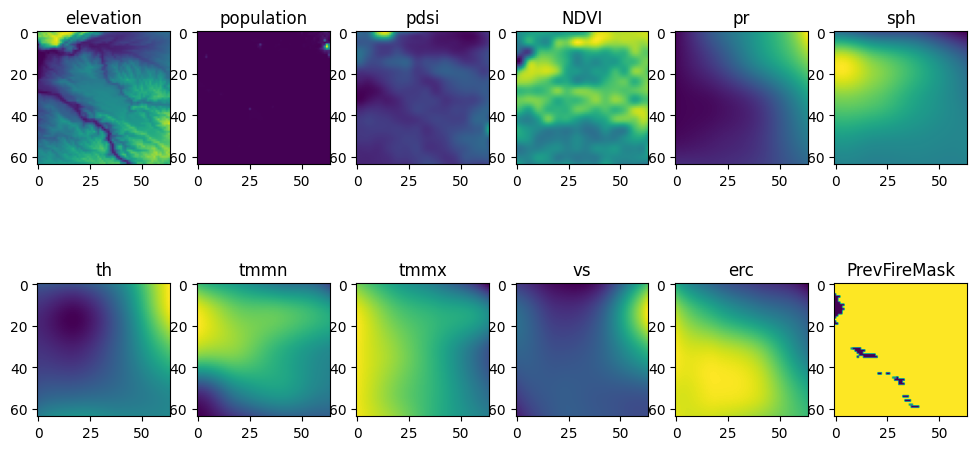

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,6, figsize=(12,6))

ax = ax.flatten()

for axs, feature in zip(ax, features):
    axs.imshow(feature_dict[feature])
    axs.set_title(feature)

# Visualization

In [ ]:
# Statistics for visualization
band_stats = {}

for image in image_list:
    bands = image.getInfo()['bands']
    for band in bands:
        band_name = band['id']

        stats = image.reduceRegion(
            reducer=ee.Reducer.minMax(),
            geometry=geometry,
            scale=10*sampling_scale,
            #maxPixels=1e5
            )

        # Get the minimum and maximum values from the statistics dictionary
        min_value = stats.get(f'{band_name}_min').getInfo()
        max_value = stats.get(f'{band_name}_max').getInfo()
        band_stats[band_name] = {'min' : min_value, 'max' : max_value}

# manually set FireMask stats
band_stats['PrevFireMask'] = {'min' : 1, 'max' : 9}
band_stats['FireMask'] = band_stats['PrevFireMask']
band_stats['detection'] = {'min' : 0, 'max' : 1}
        
band_stats

In [28]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True
      ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [51]:
fire_rgb = fire_array.reshape(64,64) * 255

fire_overlay = folium.raster_layers.ImageOverlay(
    image=fire_rgb,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    control=True
    )

fire_overlay

In [52]:
m = folium.Map(location=[35.8861, -105.5511], zoom_start=6)
m.add_ee_layer(image_list[0], vis_params={}, name='elevation')
display(m)

In [29]:
# Create a folium map object.
m = folium.Map(location=[35.8861, -105.5511], zoom_start=6)

#Add the images from image_list to the map object.
for image in image_list:
    bands = image.getInfo()['bands']
    for band in bands:
        band_name = band['id']
        image_vis = image.select(band_name)#.updateMask(image.gt(0))#.visualize(band_name)
        vis_params = {
            'min': int(feature_dict[band_name].min()),#band_stats[band_name]['min'],
            'max': int(feature_dict[band_name].max())#band_stats[band_name]['max'],
        #    #'palette' : ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
            }
        m.add_ee_layer(image_vis, vis_params, name=band_name)
        print(f'Loaded {band_name}.')

# add detection layer
#m.add_ee_layer(detection.updateMask(detection.gt(0)), {'min': 0, 'max': 1, 'palette': ['ffffff', 'ff0000']}, name='detection')

# Add test coordinates
test_json = test_coord.toGeoJSON()
folium.GeoJson(test_json).add_to(m)

# World borders
world_borders = folium.GeoJson('world-countries.json', name='Borders', style_function=(lambda feature: {'fillOpacity': 0}))

# Add the world borders layer to the map
world_borders.add_to(m)

# Add coordinate popup
m.add_child(folium.LatLngPopup())

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

Loaded elevation.
Loaded population.
Loaded pdsi.
Loaded NDVI.
Loaded pr.
Loaded sph.
Loaded th.
Loaded tmmn.
Loaded tmmx.
Loaded vs.
Loaded erc.
Loaded PrevFireMask.
Loaded FireMask.


# Module dev

In [3]:
%load_ext autoreload
%autoreload 2
from earthengine import get_ee_data

In [32]:
data = get_ee_data(start_date='2023-07-05')

Initializing Earth Engine.
Retrieving satellite images from EE.
Extracting arrays.


EEException: Image.subtract: If one image has no bands, the other must also have no bands. Got 0 and 1.

In [10]:
data.keys()

dict_keys(['FireMask', 'detection', 'elevation', 'erc', 'population', 'pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs'])